<a href="https://colab.research.google.com/github/bryanbayup/phising-detection/blob/main/final_PhisingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.0 MB/s eta 0:00:00


In [7]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from tld import get_tld, is_tld
from urllib.parse import urlparse  # Import urlparse dari urllib.parse

In [8]:
# Membaca dataset
data = pd.read_csv('malicious_phish.csv')
data2 = data.copy()

In [9]:
# Menampilkan 10 dataset teratas
data.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [10]:
# Menghapus defacements dari dataset
indexNames = data2[data2['type'] == 'defacement'].index
data2.drop(indexNames, inplace=True)

In [11]:
# Menghapus malwares dari dataset
indexNames = data2[data2['type'] == 'malware'].index
data2.drop(indexNames, inplace=True)

In [12]:
# Ekstraksi fitur
data2['url'] = data2['url'].replace('www.', '', regex=True)
rem = {"Category": {"benign": 0,  "phishing": 1}}
data2['Category'] = data2['type']
data2 = data2.replace(rem)

In [13]:
# Menambahkan fitur panjang URL
data2['url_len'] = data2['url'].apply(lambda x: len(str(x)))

In [14]:
# Menambahkan fitur domain dari URL
def process_tld(url):
    try:
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        pri_domain = res.parsed_url.netloc
    except:
        pri_domain = None
    return pri_domain

data2['domain'] = data2['url'].apply(lambda i: process_tld(i))

In [15]:
# Menambahkan fitur karakter khusus
feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
for a in feature:
    data2[a] = data2['url'].apply(lambda i: i.count(a))

In [16]:
# Menambahkan fitur apakah URL abnormal
def abnormal_url(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            match = re.search(parsed_url.hostname, url)
            if match:
                return 1
    except:
        pass
    return 0

data2['abnormal_url'] = data2['url'].apply(lambda i: abnormal_url(i))

In [17]:
# Menambahkan fitur apakah menggunakan protokol HTTPS
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match == 'https':
        return 1
    else:
        return 0

data2['https'] = data2['url'].apply(lambda i: httpSecure(i))

In [18]:
# Menambahkan fitur jumlah digit dalam URL
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits += 1
    return digits

data2['digits'] = data2['url'].apply(lambda i: digit_count(i))

In [19]:
# Menambahkan fitur jumlah huruf dalam URL
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters

data2['letters'] = data2['url'].apply(lambda i: letter_count(i))

In [21]:
# Menambahkan fitur apakah URL menggunakan layanan pemendek URL
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

data2['Shortining_Service'] = data2['url'].apply(lambda x: Shortining_Service(x))

In [22]:
# Menambahkan fitur apakah URL memiliki alamat IP
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data2['having_ip_address'] = data2['url'].apply(lambda i: having_ip_address(i))

In [23]:
# Memisahkan data menjadi fitur (X) dan label (y)
X = data2.drop(['url', 'type', 'Category', 'domain'], axis=1)
y = data2['Category']

In [24]:
# Pembagian data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [25]:
# Periksa nilai yang hilang dalam variabel y_train
print("Missing values in y_train:", y_train.isnull().sum())

Missing values in y_train: 0


In [26]:
# Periksa nilai yang hilang dalam variabel y_test
print("Missing values in y_test:", y_test.isnull().sum())

Missing values in y_test: 1


In [27]:
# Hapus nilai yang hilang dalam variabel y_test
X_test = X_test[~y_test.isnull()]
y_test = y_test.dropna()

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  98.50%  
              Classification_report 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2235
         1.0       0.93      0.85      0.89       169

    accuracy                           0.99      2404
   macro avg       0.96      0.92      0.94      2404
weighted avg       0.98      0.99      0.98      2404

             Confusion_matrix 


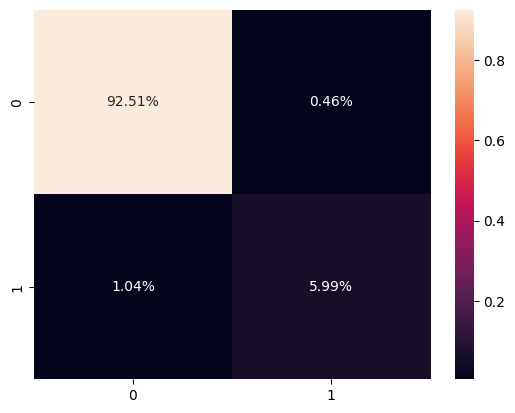

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  98.17%  
              Classification_report 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      2235
         1.0       0.95      0.78      0.86       169

    accuracy                           0.98      2404
   macro avg       0.97      0.89      0.92      2404
weighted avg       0.98      0.98      0.98      2404

             Confusion_matrix 


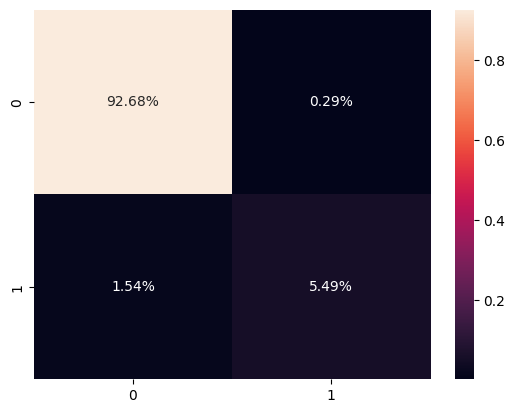

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  97.09%  
              Classification_report 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      2235
         1.0       0.98      0.60      0.74       169

    accuracy                           0.97      2404
   macro avg       0.98      0.80      0.86      2404
weighted avg       0.97      0.97      0.97      2404

             Confusion_matrix 


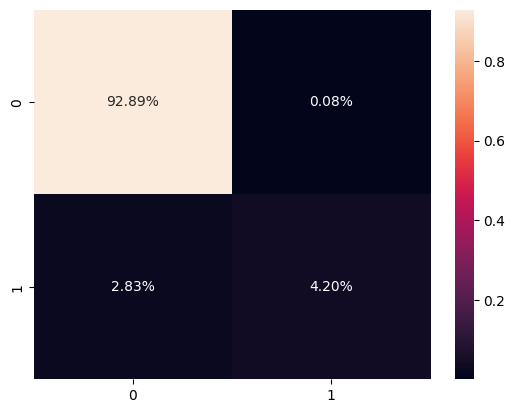

###################- End -###################


In [28]:
# Pelatihan dan evaluasi model
models = [DecisionTreeClassifier, RandomForestClassifier, SGDClassifier]
accuracy_test = []

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc * 100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

In [29]:
# Menyusun hasil evaluasi dalam DataFrame
output = pd.DataFrame({"Model": ['Decision Tree Classifier', 'Random Forest Classifier', 'SGDClassifier'],
                       "Accuracy": accuracy_test})

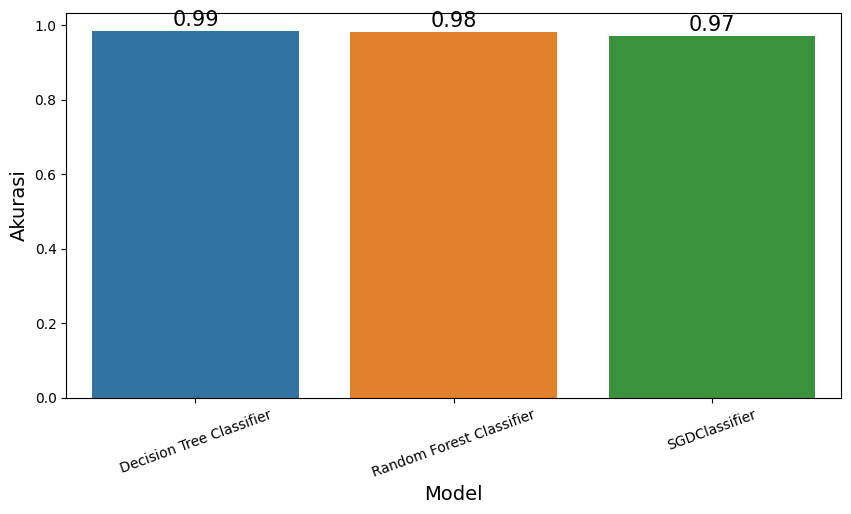

In [30]:
# Menampilkan plot hasil evaluasi
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Model", size=14)
plt.xticks(rotation=20)
plt.ylabel("Akurasi", size=14)
plt.show()

In [31]:
# Fungsi untuk mengonversi URL baru dan melakukan prediksi
def URL_Converter(urls):
    data = pd.DataFrame()
    data['url'] = pd.Series(urls)

    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['domain'] = data['url'].apply(lambda i: process_tld(i))
    feature = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))
    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: httpSecure(i))
    data['digits'] = data['url'].apply(lambda i: digit_count(i))
    data['letters'] = data['url'].apply(lambda i: letter_count(i))
    data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

    X_new = data.drop(['url', 'domain'], axis=1)

    return X_new

In [32]:
# Mengonversi dan melakukan prediksi pada URL baru 3 url pertama bukan web phising sedangkan 3 diakhir web phising
urls = ['media.caltech.edu/',
        'cyndislist.com/',
        'bopsecrets.org/',
        'http://www.marketingbyinternet.com/',
        'alexpay2.beget.tech',
        'signin.eby.de.zukruygxctzmmqi.civpro.co.za']

test_data = URL_Converter(urls)
models = [DecisionTreeClassifier, RandomForestClassifier, SGDClassifier]

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(test_data)
    print(pred)

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
[0. 0. 0. 1. 1. 1.]
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
[0. 0. 0. 1. 1. 1.]
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
[0. 0. 0. 1. 1. 1.]


In [34]:
# Menyusun hasil prediksi dalam DataFrame
output = pd.DataFrame({"Model": ['Decision Tree Classifier', 'Random Forest Classifier', 'SGDClassifier'],
                       "Accuracy": accuracy_test})

In [35]:
output

,Model,Accuracy
0,Decision Tree Classifier,0.985025
1,Random Forest Classifier,0.981697
2,SGDClassifier,0.970882
